This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week11` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

## Problem 11.1. Bayesian Linear Regression.

In this problem, we will use `pymc3` to estimate model parameters that predict `AirTime` from `Distance`.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week11/assignments/images/bayesian_linear_regression.png)

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from nose.tools import assert_equal, assert_true, assert_is_instance
from numpy.testing import assert_array_almost_equal, assert_almost_equal

We use the [airline on-time performance data](http://stat-computing.org/dataexpo/2009/). For simplicity, we limit our analysis to flights that departed from Chicago, and use every 10000th row.

In [4]:
filename = '/home/data_scientist/data/2001.csv'

usecols = (13, 16, 18)
columns = ['AirTime', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'] # use only flights departed from Chicago
local = local.dropna() # drop missing values
local = local.loc[::10000] # use every 10000th row

print(local.head())

        AirTime Origin  Distance
6367         86    ORD       599
228046       97    ORD       783
409321       92    ORD       714
708982      136    ORD      1144
857277       63    ORD       296


## Linear Regression

- Implement the following model using `pymc3`:
$$
\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta X \\
\alpha &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(10, 1) \\
\sigma &\sim \mathcal{U}(0, 100)
\end{aligned}
$$
where $\mathcal{N}$ denotes the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) and $\mathcal{U}$ is the [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous).

- Use the names `alpha`, `beta`, and `sigma` for $\alpha$, $\beta$, and $\sigma$, respectively.
- Estimate the model paramters with the maximum a posteriori (MAP) method (using default parameters).
- Use the No-U-Turn Sampler (NUTS) to generate posterior samples.
- Use the `random_seed` parameter in `pymc3.sample()` method for reproducibility.

In [11]:
def get_trace(X, y, n_samples=1000, random_seed=0):
    '''
    A simple Bayesian linear regression model with normal priors.
    
    Paramters
    ---------
    X: A numpy array
    y: A numpy array
    n_samples: The number of samples to draw in pymc3.sample().
               Defaults to 1000.
    random_seed: An int. Used in pymc3.sample().
                 Defaults to 0.
                 
    Returns
    -------
    A pymc3.MultiTrace object with access to sampling values.
    '''
    
    # YOUR CODE HERE
    with pm.Model() as linear_model:
        alpha = pm.Normal('alpha', mu = 0, sd = 1.0)
        beta = pm.Normal('beta', mu = 10, sd = 1.0)
        sigma = pm.Uniform('sigma', lower = 0, upper = 100)
        y_exp =  alpha + beta * X
        likelihood = pm.Normal('y', mu=y_exp, sd=sigma, observed=y)
        
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace = pm.sample(n_samples, step=step, start=start, progressbar=True, random_seed=random_seed)
    
    
        
    return trace

In [12]:
trace = get_trace(local.Distance.values, local.AirTime.values, n_samples=2000, random_seed=0)

Applied interval-transform to sigma and added transformed sigma_interval to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.2 sec

## Tests

In [13]:
assert_is_instance(trace, pm.backends.base.MultiTrace)

In [14]:
assert_true('alpha' in trace.varnames)
assert_true('beta' in trace.varnames)
assert_true('sigma' in trace.varnames)

In [15]:
for v in trace.varnames:
    assert_equal(len(trace[v]), 2000)

In [16]:
assert_almost_equal(trace['alpha'][0], 0.44122036)
assert_almost_equal(trace['beta'][0], 0.12959348068373655)
assert_almost_equal(trace['sigma'][0], 12.467518196594149)

In [17]:
assert_array_almost_equal(
    trace['alpha'][-5:],
    [ 0.16324791,  1.82571865,  0.67204558,  1.02240237,  0.21551398]
    )
assert_array_almost_equal(
    trace['beta'][-5:],
    [ 0.13080994,  0.12731913,  0.13123427,  0.12632491,  0.12939133]
    )
assert_array_almost_equal(
    trace['sigma'][-5:],
    [ 16.8066625 ,  11.335856  ,  11.94498544,  14.47516706,  13.6487422 ]
    )

## Model Checking

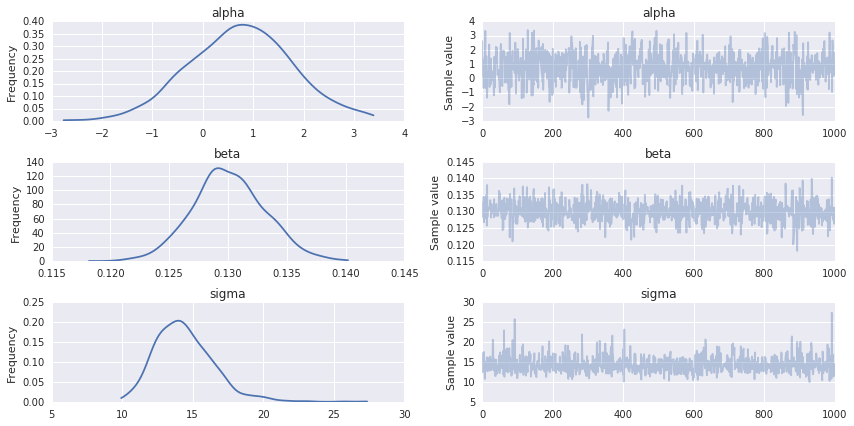

In [18]:
# Plot traces
sns.set_style('darkgrid')
pm.traceplot(trace[-1000:], ['alpha', 'beta', 'sigma'])
plt.show()

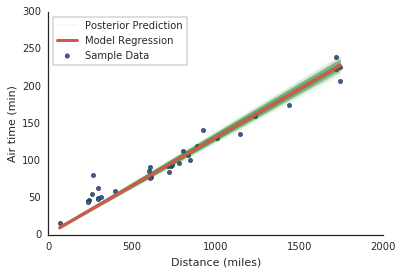

In [19]:
n_samples = 1000

x = local.Distance.values
y = local.AirTime.values

sns.set_style('white')

fig, ax = plt.subplots()

ax.scatter(x, y, c=sns.xkcd_rgb['denim blue'], label = 'Sample Data')

xl = x.min()
xh = x.max()

intercepts = trace['alpha'][-n_samples:]
slopes = trace['beta'][-n_samples:]

for m, b in zip(slopes, intercepts):
    yl = m * xl + b
    yh = m * xh + b
    ax.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['medium green'], lw=0.1, alpha = 0.1)

# Replot last one to get legend label
ax.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['medium green'], lw=0.1, label = 'Posterior Prediction')

m_fit = slopes.mean()
b_fit = intercepts.mean()

yfl = b_fit + m_fit * xl
yfh = b_fit + m_fit * xh
ax.plot((xl, xh), (yfl, yfh), color=sns.xkcd_rgb['pale red'], lw=3, label='Model Regression')

ax.set_xlim(0, 2000)
ax.set_ylim(0, 300)

ax.legend(loc='upper left', frameon=True)

ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Air time (min)')

sns.despine()

plt.show()